# CHAPTER 08. 텍스트 분석
## 09. 한글 텍스트 처리 - 네이버 영화 평점 감상 분석
### 한글 NLP 처리의 어려움
한글 언어 처리는 영어 등의 라틴어 처리보다 어렵다. 그 주된 원인은 '띄어쓰기'와 '다양한 조사' 때문이다.

### KoNLPy 소개
: KoNLPy는 파이썬의 대표적인 한글 형태소 패키지이다. 형태소의 사전적인 의미는 '단어로서 의미를 가지는 최소 단위'로 정의할 수 있다. 형태소 분석이란 말뭉치를 이러한 형태소 어근 단위로 쪼개고 각 형태소에 품사 태깅을 부착하는 작업을 일반적으로 지칭한다. 꼬꼬마(Kkma), 한나눔(Hannanum), Komoran, 은전한닢 프로젝트(Mecab), Twitter와 같이 5개의 형태소 분석 모듈을 사용할 수 있다.

### 데이터 로딩

In [2]:
import pandas as pd

train_df = pd.read_csv('/Users/wizdom/Desktop/data_analysis/파이썬 머신러닝 완벽가이드/실습 데이터/nsmc-master/ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [3]:
# 학습 데이터 세트의 0과 1의 label 값 비율 살펴보기
# 1이 긍정, 0이 부정

train_df['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

0과 1의 비율이 어느 한쪽으로 치우치지 않고 균등한 분포를 나타내고 있다.

In [4]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용해 숫자를 공백으로 변경(단어적인 의미로 부족하므로)
train_df['document'] = train_df['document'].apply(lambda x : re.sub(r"\d+"," ", x))

# 테스트 데이터 세트를 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('/Users/wizdom/Desktop/data_analysis/파이썬 머신러닝 완벽가이드/실습 데이터/nsmc-master/ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply(lambda x : re.sub(r"\d+", " ", x))

# id 칼럼 삭제 수행
train_df.drop('id', axis=1, inplace=True)
test_df.drop('id', axis=1, inplace=True)

In [7]:
# 각 문장을 한글 형태소 분석을 통해 형태소 단어로 토큰화하는 함수

from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
    # morphs() : 입력 인자로 들어온 텍스트를 형태소 단어로 토큰화해 리스트 형태로 반환
    tokens_ko = twitter.morphs(text)
    return tokens_ko

/opt/anaconda3/lib/python3.8/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [13]:
# TF-IDF 피처 모델 생성
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs() 객체를 이용한 tokenizer를 사용. ngram_range는 (1, 2)
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1, 2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

In [14]:
# 로지스틱 회귀를 이용해 감성 분석 분류 수행
lg_clf = LogisticRegression(random_state=0)

# 파라미터 C 최적화를 위해 GridSearchCV를 이용
params = {'C': [1, 3.5, 4.5, 5.5, 10]}

grid_cv = GridSearchCV(lg_clf, param_grid=params, cv=3, scoring='accuracy', verbose=1)
grid_cv.fit(tfidf_matrix_train, train_df['label'])
print(grid_cv.best_params_, round(grid_cv.best_score_, 4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:

{'C': 4.5} 0.8592


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
# 테스트 세트를 이용해 최종 감성 분석 예측 수행

from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidVectorizer를 이용해 테스트 데이터를 TF-IDF 값으로 피처 변환
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도:', accuracy_score(test_df['label'], preds))

Logistic Regression 정확도: 0.86178


## 10. 텍스트 분석 실습 - 캐글 Mercari Price Suggestion Challenge
일본의 대형 온라인 쇼핑몰인 Mercari사의 제품에 대해 가격 예측하는 과제. 이번 Mercari Price Suggestion이 기존 회귀 예제와 다른 점은 텍스트 형태의 비정형 데이터와 다른 정형 속성을 같이 적용해 회귀를 수행한다는 점이다.

### 데이터 전처리

In [1]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd

mercari_df = pd.read_csv('/Users/wizdom/Desktop/data_analysis/파이썬 머신러닝 완벽가이드/실습 데이터/mercari_train.tsv', sep='\t')
print(mercari_df.shape)
mercari_df.head(3)

(1482535, 8)


,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...


In [2]:
# 피처 타입과 null 여부 확인
print(mercari_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   train_id           1482535 non-null  int64  
 1   name               1482535 non-null  object 
 2   item_condition_id  1482535 non-null  int64  
 3   category_name      1476208 non-null  object 
 4   brand_name         849853 non-null   object 
 5   price              1482535 non-null  float64
 6   shipping           1482535 non-null  int64  
 7   item_description   1482531 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB
None


brand_name은 가격에 영향을 미치는 중요 요인으로 판단되지만, 많은 데이터가 Null로 되어있다. categoty_name은 약 6300건의 null 데이터를 가지고 있으며, item_description의 null 값은 4건으로 미비하다.

/opt/anaconda3/envs/py3.7/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price'>

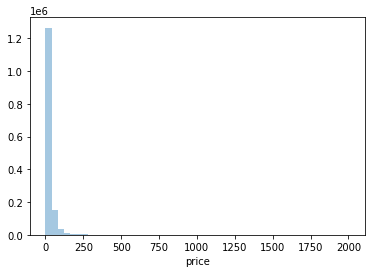

In [3]:
# Target 값인 price 칼럼의 데이터 분포도 살펴보기

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

y_train_df = mercari_df['price']
plt.figure(figsize=(6, 4))
sns.distplot(y_train_df, kde=False)

price 값이 비교적 적은 가격을 가진 데이터 값에 왜곡돼 분포돼 있다.

<AxesSubplot:xlabel='price'>

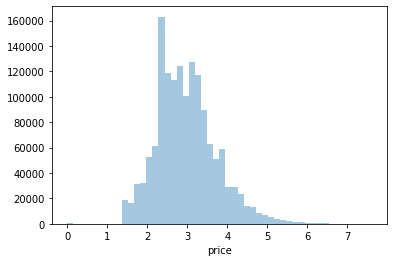

In [4]:
# price 칼럼은 로그 값으로 변환한 뒤 분포도 다시 살펴보기

import numpy as np
y_train_df = np.log1p(y_train_df)
sns.distplot(y_train_df, kde=False)

로그 값으로 변환하면 price 값이 비교적 정규 분포에 가까운 데이터를 이루게 된다.

In [5]:
# 데이터 세트의 price 칼럼을 원래 값에서 로그로 변환한 값으로 변경
mercari_df['price'] = np.log1p(mercari_df['price'])
mercari_df['price'].head(3)

0    2.397895
1    3.970292
2    2.397895
Name: price, dtype: float64

In [6]:
# 다른 피처 값 살펴보기
print('Shipping 값 유형: \n', mercari_df['shipping'].value_counts())
print('\nitem_condition_id 값 유형: \n', mercari_df['item_condition_id'].value_counts())

Shipping 값 유형: 
 0    819435
1    663100
Name: shipping, dtype: int64

item_condition_id 값 유형: 
 1    640549
3    432161
2    375479
4     31962
5      2384
Name: item_condition_id, dtype: int64


Shipping 칼럼은 배송비 유무이며, 값이 비교적 균일하다. Item_condition_id는 판매자가 제공하는 제품 상태로서 1, 2, 3 값이 주를 이루고 있다.

In [7]:
# item_description 칼럼의 'No description yet' 값 살펴보기
boolean_cond = mercari_df['item_description'] == 'No description yet'
mercari_df[boolean_cond]['item_description'].count()

82489

이 값도 Null과 마찬가지로 의미 있는 속성값으로는 사용될 수 없으므로 적절한 값으로 변경해야한다.

In [8]:
# category_name 칼럼의 카테고리 분류하기
# apply lambda에서 호출되는 대, 중, 소 분할 함수 생성, 대, 중, 소 값을 리스트로 반환
def split_cat(category_name):
    try:
        return category_name.split('/')
    except:
        return ['Other_Null', 'Other_Null', 'Other_Null']
    
# 위의 split_cat()을 apply lambda에서 호출해 대, 중, 소 칼럼을 mercari_df에 생성
mercari_df['cat_dae'], mercari_df['cat_jung'], mercari_df['cat_so'] = \
zip(*mercari_df['category_name'].apply(lambda x : split_cat(x)))

# 대분류만 값의 유형과 건수를 살펴보고, 중분류 ,소분류는 값의 유형이 많으므로 분류 개수만 추출
print('대분류 유형 :\n', mercari_df['cat_dae'].value_counts())
print('\n중분류 개수 :', mercari_df['cat_jung'].nunique())
print('소분류 개수 :', mercari_df['cat_so'].nunique())

대분류 유형 :
 Women                     664385
Beauty                    207828
Kids                      171689
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Other_Null                  6327
Name: cat_dae, dtype: int64

중분류 개수 : 114
소분류 개수 : 871


In [9]:
# brand_name, category_name, item_description 칼럼의 Null 값 변경하기

mercari_df['brand_name'] = mercari_df['brand_name'].fillna(value='Other_Null')
mercari_df['category_name'] = mercari_df['category_name'].fillna(value='Other_Null')
mercari_df['item_description'] = mercari_df['item_description'].fillna(value='Other_Null')

In [10]:
# 각 칼럼별로 Null값 건수 확인
mercari_df.isnull().sum()

train_id             0
name                 0
item_condition_id    0
category_name        0
brand_name           0
price                0
shipping             0
item_description     0
cat_dae              0
cat_jung             0
cat_so               0
dtype: int64

### 피처 인코딩과 피처 벡터화
Mercari Price Suggestion에 이용되는 데이터 세트는 문자열 칼럼이 많다. 이 문자열 칼럼 중 레이블 또는 원-핫 인코딩을 수행하거나 피처 벡터화로 변환할 칼럼 선별해 보자

예측 모델은 price 값, 즉 상품 가격을 예측해야 하므로 회귀모델을 기반으로 한다. 선형 회귀의 경우 원-핫 인코딩 적용이 훨씬 선호되므로 인코딩할 피처는 모두 원-핫 인코딩을 적용하기. 


피처 벡터화의 경우는 짧은 텍스트의 경우는 count 기반의 벡터화, 긴 텍스트는 TD-IDF 기반의 벡터화 적용

In [11]:
# brand_name 칼럼 검토
print('brand name의 유형 건수:', mercari_df['brand_name'].unique())
print('\nbrand name sample 5건: \n', mercari_df['brand_name'].value_counts()[:5])

brand name의 유형 건수: ['Other_Null' 'Razer' 'Target' ... 'Astroglide' 'Cumberland Bay'
 'Kids Only']

brand name sample 5건: 
 Other_Null           632682
PINK                  54088
Nike                  54043
Victoria's Secret     48036
LuLaRoe               31024
Name: brand_name, dtype: int64


대부분 명료한 문자열로 돼 있다. 별도의 피처 벡터화 형태로 만들 필요 없이 인코딩 변환 적용하면 된다. 따라서 원-핫 인코딩 변환하도록 한다.

In [12]:
# name 칼럼 검토
print('name의 종류 건수:', mercari_df['name'].unique())
print('\nname sample 5건: \n', mercari_df['name'][:10])

name의 종류 건수: ['MLB Cincinnati Reds T Shirt Size XL' 'Razer BlackWidow Chroma Keyboard'
 'AVA-VIV Blouse' ... '21 day fix containers and eating plan'
 'World markets lanterns' 'Brand new lux de ville wallet']

name sample 5건: 
 0       MLB Cincinnati Reds T Shirt Size XL
1          Razer BlackWidow Chroma Keyboard
2                            AVA-VIV Blouse
3                     Leather Horse Statues
4                      24K GOLD plated rose
5          Bundled items requested for Ruie
6        Acacia pacific tides santorini top
7      Girls cheer and tumbling bundle of 7
8                     Girls Nike Pro shorts
9    Porcelain clown doll checker pants VTG
Name: name, dtype: object


종류가 매우 많다. 전체 데이터가 개별적으로 거의 고유한 상품명을 가지고 있다는 것을 알 수 있다. 이렇게 유형이 매우 많고 적은 단어 위주의 텍스트 형태로 돼 있으므로 count기반의 피처 벡터화 변환 적용한다.

In [13]:
# item_description 칼럼 검토
pd.set_option('max_colwidth', 200)

# item_description의 평균 문자열 크기
print('item_description 평균 문자열 크기:', mercari_df['item_description'].str.len().mean())

mercari_df['item_description'][:2]

item_description 평균 문자열 크기: 145.7113889385411


0                                                                                                                                                                              No description yet
1    This keyboard is in great condition and works like it came out of the box. All of the ports are tested and work perfectly. The lights are customizable via the Razer Synapse app on your PC.
Name: item_description, dtype: object

평균 문자열이 145자로 비교적 크므로 TF-IDF로 변환한다.

#### 주요 칼럼 인코딩 및 피처 벡터화 변환

In [14]:
# name 속성에 대한 피처 벡터화 변환
cnt_vec = CountVectorizer()
X_name = cnt_vec.fit_transform(mercari_df.name)

# item_description에 대한 피처 벡터화 변환
tfidf_descp = TfidfVectorizer(max_features=50000, ngram_range=(1, 3), stop_words='english')
X_descp = tfidf_descp.fit_transform(mercari_df['item_description'])

print('name vectorization shape:', X_name.shape)
print('item_description vectorization shape:', X_descp.shape)

name vectorization shape: (1482535, 105757)
item_description vectorization shape: (1482535, 50000)


CountVectorizer, TfidfVectorizer는 희소 행렬 형태로 반환하므로 X_name, X_descp를 새로 결합해 새로운 데이터 세트로 구성해야하고, 앞으로 인코딩 될 다른 칼럼들도 모두 이 둘 변수와 결합돼 ML 모델을 실행하는 기반 데이터 세트로 재구성돼야 한다.

In [15]:
# 이를 위해 인코딩 대상 칼럼도 밀집 행렬 형태가 아닌 희소 행렬 형태로 인코딩을 적용한 뒤, 함께 결합

from sklearn.preprocessing import LabelBinarizer

# brand_name, item_condition_id, shipping 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_brand_name = LabelBinarizer(sparse_output=True)
X_brand = lb_brand_name.fit_transform(mercari_df['brand_name'])
lb_item_cond_id = LabelBinarizer(sparse_output=True)
X_item_cond_id = lb_item_cond_id.fit_transform(mercari_df['item_condition_id'])
lb_shipping = LabelBinarizer(sparse_output=True)
X_shipping = lb_shipping.fit_transform(mercari_df['shipping'])

# cat_dae, cat_jung, cat_so 각 피처들을 희소 행렬 원-핫 인코딩 변환
lb_cat_dae = LabelBinarizer(sparse_output=True)
X_cat_dae = lb_cat_dae.fit_transform(mercari_df['cat_dae'])
lb_cat_jung = LabelBinarizer(sparse_output=True)
X_cat_jung = lb_cat_jung.fit_transform(mercari_df['cat_jung'])
lb_cat_so = LabelBinarizer(sparse_output=True)
X_cat_so = lb_cat_so.fit_transform(mercari_df['cat_so'])

- **LabelBinarizer 클래스** : 희소 행렬 혀애의 원-핫 인코딩 변환 지원
    - 생성시 **sparse_out=True**로 파라미터 설정


- sparse 모듈의 **hstack() 함수** : 희소 행렬을 손쉽게 칼럼 레벨로 결합

In [16]:
# 제대로 변환됐는지 생성된 인코딩 데이터 세트의 타입과 shape 살펴보기
print(type(X_brand), type(X_item_cond_id), type(X_shipping))
print('X_brand shape:{0}, X_tem_cond_id shape:{1}'.format(X_brand.shape, X_item_cond_id.shape))
print('X_shipping shape:{0}, X_cat_dae shape:{1}'.format(X_shipping.shape, X_cat_dae.shape))
print('X_cat_jung shape:{0}, X_cat_so shape:{1}'. format(X_cat_jung.shape, X_cat_so.shape))

<class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'> <class 'scipy.sparse.csr.csr_matrix'>
X_brand shape:(1482535, 4810), X_tem_cond_id shape:(1482535, 5)
X_shipping shape:(1482535, 1), X_cat_dae shape:(1482535, 11)
X_cat_jung shape:(1482535, 114), X_cat_so shape:(1482535, 871)


인코딩 변환된 데이터 세트가 CSR 형태로 변환된 csr_matrix 타입이다. 그리고 인코딩 칼럼이 매우 많이 생겼지만, 피처 벡터화로 텍스트 형태의 문자열이 가지는 벡터 형태의 매우 많은 칼럼과 함께 결합되므로 크게 문제될 것은 없다.

In [17]:
# 앞에서 피처 벡터화 변환한 데이터 세트와 희소 인코딩 변환된 데이터 세트를 hstack()을 이용해 모두 결합

from scipy.sparse import hstack
import gc

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

# hstack 함수를 이용해 인코딩과 벡터화를 수행한 데이터 세트를 모두 결합
X_features_sparse = hstack(sparse_matrix_list).tocsr()
print(type(X_features_sparse), X_features_sparse.shape)

# 데이터 세트가 메모리를 많이 차지하므로 사용 목적이 끝났으면 바로 메모리에서 삭제
del X_features_sparse
gc.collect()

<class 'scipy.sparse.csr.csr_matrix'> (1482535, 161569)


60

- del '객체 변수명'과 gc.collect()로 결합 데이터 메모리에서 삭제

### 릿지 회귀 모델 구축 및 평가 
적용할 평가지표는 RMSLE 방식으로 RMSE와 유사하나 오류값에 로그를 취해 RMSE를 구하는 방식이다. 낮은 가격보다 높은 가격에서 오류가 발생할 경우 오류 값이 더 커지는 것을 억제하기 위해 이 방식을 도입했다.

In [18]:
# RMSLE를 구하는 함수 생성

def rmsle(y, y_pred):
    # underflow, overflow를 막기 위해 log가 아닌 log1p로 rmsle 계산
    return np.sqrt(np.mean(np.power(np.log1p(y) - np.log1p(y_pred), 2)))

def evaluate_org_price(y_test, preds):
    
    # 원본 데이터는 log1p로 변환되었으므로 exmpm1로 원복 필요
    preds_exmpm = np.expm1(preds)
    y_test_exmpm = np.expm1(y_test)
    
    # rmsle로 RMSLE 값 추출
    rmsle_result = rmsle(y_test_exmpm, preds_exmpm)
    return rmsle_result

- np.power : 첫번째 배열의 원소에, 두번째 배열의 원소만큼 제곱

In [19]:
# 학습용 데이터를 생성하고, 모델을 학습/예측하는 로직을 별도의 함수로 만들기

import gc
from scipy.sparse import hstack

def model_train_predict(model, matrix_list):
    # scipy.sparse 모듈의 hstack을 이용해 희소 행렬 결합
    X = hstack(matrix_list).tocsr()
    
    X_train, X_test, y_train, y_test = train_test_split(X, mercari_df['price'],
                                                       test_size=0.2, random_state=156)
    
    # 모델 학습 및 예측
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    del X, X_train, X_test, y_train
    gc.collect()
    
    return preds, y_test

In [20]:
# Ridge를 이용해 Mercari Price의 회귀 예측 수행
linear_model = Ridge(solver="lsqr", fit_intercept=False)

# 수행 전에 상품 가격 예측에 item_description과 같은 텍스트 형태의 속성이 얼마나 영향을 미치는지 알아보기
sparse_matrix_list = (X_name, X_brand, X_item_cond_id, \
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 제외했을 때 rmsle 값:', evaluate_org_price(y_test, linear_preds))

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id, \
                     X_shipping, X_cat_dae, X_cat_jung, X_cat_so)
linear_preds, y_test = model_train_predict(model=linear_model, matrix_list=sparse_matrix_list)
print('Item Description을 포함한 rmsle 값:', evaluate_org_price(y_test, linear_preds))

Item Description을 제외했을 때 rmsle 값: 0.5021655280454068
Item Description을 포함한 rmsle 값: 0.4712204443532744


Item Description을 포함했을 때 rmsle값이 많이 감소했으므로 item description 영향이 중요함을 알 수 있다.

### LightGBM 회귀 모델 구축과 앙상블을 이용한 최종 예측 평가
LightGBM을 이용해 회귀를 수행한 뒤, 위에서 구한 릿지 모델 예측값과 LightGBM 모델 예측값을 간단한 앙상블 방식으로 섞어서 최종 회귀 예측값 평가

In [21]:
# 먼저 LightGBM으로 회귀 수행
from lightgbm import LGBMRegressor

sparse_matrix_list = (X_name, X_descp, X_brand, X_item_cond_id,
                      X_shipping, X_cat_dae, X_cat_jung, X_cat_so)

lgbm_model = LGBMRegressor(n_estimators=200, learning_rate=0.5, num_leaves=125, random_state=156)
lgbm_preds, y_test = model_train_predict(model=lgbm_model, matrix_list=sparse_matrix_list)
print('LightGBM rmsle 값:', evaluate_org_price(y_test, lgbm_preds))

LightGBM rmsle 값: 0.4562864901655035


앞 예제의 Ridge보다 예측 성능이 더 나아졌다. 

In [22]:
# LightGBM 예측 결괏값과 위에서 구한 Ridge 예측 결괏값을 서로 앙상블해 최종 예측 결괏값 도출

# 배합 비율 임의로 산정
preds = lgbm_preds * 0.45 + linear_preds * 0.55
print('LightGBM과 Ridge를 ensemble한 최종 rmsle값:', evaluate_org_price(y_test, preds))

LightGBM과 Ridge를 ensemble한 최종 rmsle값: 0.45034298503184883
